In [28]:
import numpy as np
import math
from scipy.fftpack import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageDraw, ImageOps
import cv2
import copy
from bitarray import bitarray

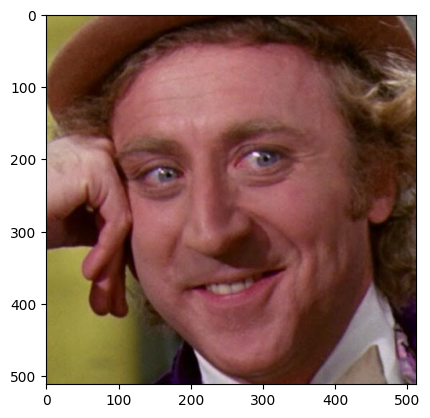

In [29]:
#загрузим на изображение, которое будем использовать в качестве контейнера
container = Image.open("in/meme.bmp")
plt.imshow(container)

In [30]:
#размеры контейнера
container_width = container.size[0]
container_height = container.size[1]
container_pix = container.load()
container_arr = np.asarray(container).copy()
container_arr = cv2.cvtColor(container_arr, cv2.COLOR_RGB2HSV)
print(container_width, container_height)

512 512


In [31]:
# маска
n = 8
mask = np.where(np.random.rand(n,n) < 0.5, 0, 1)
mask

array([[0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 1],
       [1, 0, 1, 0, 1, 0, 1, 1],
       [1, 0, 1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0]])

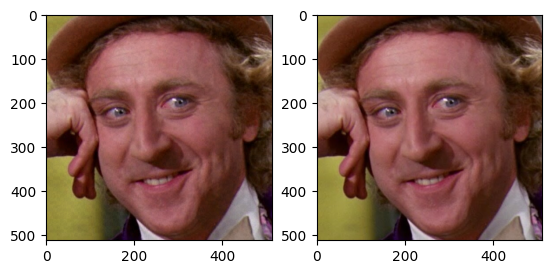

In [32]:
def langelaar(arr, mask, key):
    # порог
    a = 5
    h,s,v = cv2.split(arr)

    keyLength = len(key)
    keyIterator = 0

    b1_len = np.count_nonzero(mask)
    b0_len = n*n-b1_len

    for i in range(0, container_height-n, n):
        for j in range(0, container_width-n, n):
            if (keyIterator >= keyLength):
                return cv2.merge((h, s, v))

            # считаем среднюю яркости субблоков - l0 и l1
            b0_sum = 0
            b1_sum = 0
            for k in range(0, n, 1):
                for l in range(0, n, 1):
                    if mask[k][l] == 0:
                        b0_sum += v[i+k][j+l]
                    else:
                        b1_sum += v[i+k][j+l]

            l0 = b0_sum/b0_len
            l1 = b1_sum/b1_len

            # проверяем условие встраивания бита ЦВЗ
            if (int(key[keyIterator]) == 1 and l0 - l1 > a):
                keyIterator+=1
                continue

            if (key[keyIterator] == 0 and l0 - l1 < -a):
                keyIterator+=1
                continue

            # если условие не выполняется - меняем яркость блока b1
            for k in range(0, n, 1):
                for l in range(0, n, 1):
                    # элементы блока b0 пропускаем
                    if (mask[k][l] == 0):
                        continue
                    # если нужно встроить единицу, то надо уменьшить яркость на delta
                    if key[keyIterator] == 1:
                        delta = math.ceil(a - (l0-l1))
                        if v[i+k][j+l] - delta <= 0:
                            v[i+k][j+l] = 0
                        else:
                            v[i+k][j+l] -= delta
                    # если встроить ноль, то надо увеличить яркость на delta
                    else:
                        delta = math.ceil(a - (l1-l0))
                        if v[i+k][j+l] + delta >= 255:
                            v[i+k][j+l] = 255
                        else:
                            v[i+k][j+l] += delta
            keyIterator+=1
      
    return cv2.merge((h, s, v))

def s_to_bitlist(s):
    ords = (ord(c) for c in s)
    shifts = (7, 6, 5, 4, 3, 2, 1, 0)
    return [(o >> shift) & 1 for o in ords for shift in shifts]

def bitlist_to_chars(bl):
    bi = iter(bl)
    bytes = zip(*(bi,) * 8)
    shifts = (7, 6, 5, 4, 3, 2, 1, 0)
    for byte in bytes:
        yield chr(sum(bit << s for bit, s in zip(byte, shifts)))

def bitlist_to_s(bl):
    return ''.join(bitlist_to_chars(bl))


key = "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec molestie mi quis mauris faucibus suscipit. Nullam ultrices sem sit amet mi aliquam, vitae efficitur justo malesuada. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec cursus eros in turpis interdum aliquam. Duis non velit non nisl laoreet lobortis quis quis eros. Integer eu dapibus nulla. Fusce tincidunt sit amet tortor pretium finibus. Nulla facilisi. Proin ultricies ipsum arcu, vitae hendrerit ex rhoncus sed. Maecenas euismod lorem at lectus feugiat, facilisis venenatis mauris vehicula. Praesent massa arcu, tristique eget nulla a, gravida ultrices ipsum."
after = langelaar(container_arr, mask, s_to_bitlist(key))
test = cv2.cvtColor(after, cv2.COLOR_HSV2RGB)
plt.imsave("mid/encoded.bmp",test)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(test)
axarr[1].imshow(container)


In [33]:
def extract(arr, mask):
    h,s,v = cv2.split(arr)

    key = bitarray(6000000)
    iter = 0

    b1_len = np.count_nonzero(mask)
    b0_len = n*n-b1_len

    for i in range(0, container_height-n, n):
        for j in range(0, container_width-n, n):
            # считаем среднюю яркости субблоков - l0 и l1
            b0_sum = 0
            b1_sum = 0
            for k in range(0, n, 1):
                for l in range(0, n, 1):
                    if mask[k][l] == 0:
                        b0_sum += v[i+k][j+l]
                    else:
                        b1_sum += v[i+k][j+l]

            l0 = b0_sum/b0_len
            l1 = b1_sum/b1_len

            if l0 > l1:
                key[iter] = 1
            else:
                key[iter] = 0
            
            iter+=1
    
    return key

after_key = extract(after, mask)
print(key)
print(bitlist_to_s(after_key))

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec molestie mi quis mauris faucibus suscipit. Nullam ultrices sem sit amet mi aliquam, vitae efficitur justo malesuada. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec cursus eros in turpis interdum aliquam. Duis non velit non nisl laoreet lobortis quis quis eros. Integer eu dapibus nulla. Fusce tincidunt sit amet tortor pretium finibus. Nulla facilisi. Proin ultricies ipsum arcu, vitae hendrerit ex rhoncus sed. Maecenas euismod lorem at lectus feugiat, facilisis venenatis mauris vehicula. Praesent massa arcu, tristique eget nulla a, gravida ultrices ipsum.
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec molestie mi quis mauris faucibus suscipit. Nullam ultrices sem sit amet mi aliquam, vitae efficitur justo malesuada. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec cursus eros in turpis interdum aliquam. Duis non velit non nisl laoreet lobortis quis quis eros. Integer eu dapibus nu

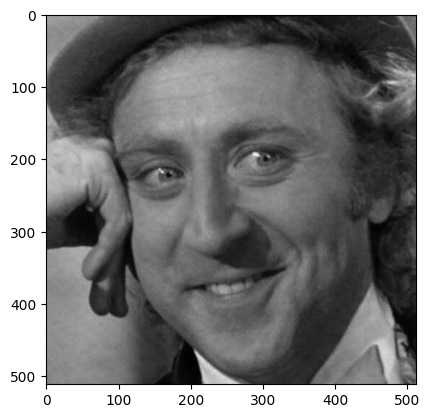

In [34]:
pre_holo = Image.open("mid/encoded.bmp", mode="r").convert("L")
np_pre_holo = np.array(pre_holo, dtype=float) / 255.0
plt.imshow(pre_holo, cmap="gray")

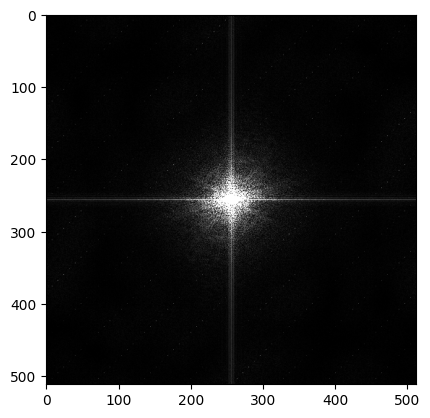

In [35]:
holo = np.fft.fftshift(np.fft.fft2(np_pre_holo))
out_holo = np.empty(shape=(512, 512))

for i in range(0, 512, 1):
    for j in range(0, 512, 1):
        out_holo[i][j] = math.sqrt(math.pow(holo[i][j].real,2)+math.pow(holo[i][j].imag,2))

im = Image.fromarray(out_holo)
plt.imsave("out/holo.bmp",im)
plt.imshow(im)

[[0.34901961 0.34509804 0.34901961 ... 0.33333333 0.34117647 0.34901961]
 [0.35294118 0.36078431 0.35294118 ... 0.32156863 0.34117647 0.34901961]
 [0.36078431 0.35294118 0.34117647 ... 0.34117647 0.33333333 0.3372549 ]
 ...
 [0.3254902  0.33333333 0.32156863 ... 0.32941176 0.3372549  0.34901961]
 [0.34509804 0.31764706 0.33333333 ... 0.31764706 0.32156863 0.34901961]
 [0.34117647 0.33333333 0.33333333 ... 0.32941176 0.3372549  0.33333333]]


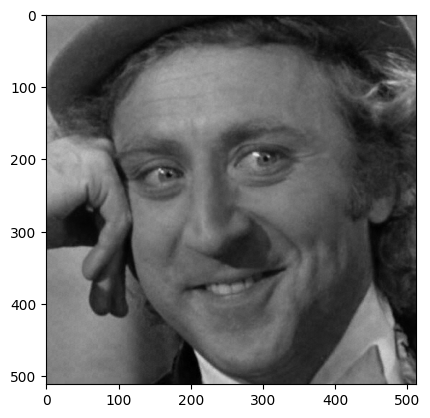

In [36]:
after_holo = np.fft.fftshift(np.fft.ifft2(holo))

out_after_holo = np.empty(shape=(512, 512))

for i in range(0, 512, 1):
    for j in range(0, 512, 1):
        out_after_holo[i][j] = math.sqrt(math.pow(after_holo[i][j].real,2)+math.pow(after_holo[i][j].imag,2))

print(out_after_holo)
out_after_holo = np.abs(out_after_holo) * 256
out_after_holo = np.roll(out_after_holo, len(out_after_holo)//2, axis=0)
out_after_holo = np.roll(out_after_holo, len(out_after_holo)//2, axis=1)

im = Image.fromarray(out_after_holo)
plt.imsave("out/decoded.bmp",out_after_holo,cmap="gray")
plt.imshow(im)

In [37]:
secret = Image.open("in/meme.bmp")
secret_arr = np.asarray(secret).copy()
secret_arr = cv2.cvtColor(secret_arr, cv2.COLOR_RGB2HSV)

holo_key = extract(secret_arr, mask)
print(key)
print(bitlist_to_s(after_key))

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec molestie mi quis mauris faucibus suscipit. Nullam ultrices sem sit amet mi aliquam, vitae efficitur justo malesuada. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec cursus eros in turpis interdum aliquam. Duis non velit non nisl laoreet lobortis quis quis eros. Integer eu dapibus nulla. Fusce tincidunt sit amet tortor pretium finibus. Nulla facilisi. Proin ultricies ipsum arcu, vitae hendrerit ex rhoncus sed. Maecenas euismod lorem at lectus feugiat, facilisis venenatis mauris vehicula. Praesent massa arcu, tristique eget nulla a, gravida ultrices ipsum.
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec molestie mi quis mauris faucibus suscipit. Nullam ultrices sem sit amet mi aliquam, vitae efficitur justo malesuada. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec cursus eros in turpis interdum aliquam. Duis non velit non nisl laoreet lobortis quis quis eros. Integer eu dapibus nu